In [ ]:
# To mount Google Drive to access files stored in the drive:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# System-level utilities
import os  # For interacting with the operating system (e.g., file paths, environment variables)
import sys  # For system-specific parameters and functions

# Numerical and data manipulation libraries
import numpy as np  # For numerical computations, including matrix operations
import pandas as pd  # For data manipulation and analysis

# Image processing and file handling
from PIL import Image  # For opening, manipulating, and saving image files
import glob  # For file pattern matching and path handling

# Collections module
from collections import defaultdict  # For creating default dictionaries with default values

# TensorFlow and Keras for deep learning
import tensorflow as tf  # Core library for building and training machine learning models
from tensorflow import keras  # High-level API for building neural networks
from tensorflow.keras import layers, Model  # For defining layers and building custom models
from tensorflow.keras.optimizers import Adam  # Optimizer for training models
from tensorflow.keras.preprocessing.image import ImageDataGenerator  # For augmenting and preprocessing image data
from keras.models import Sequential  # For creating a sequential neural network model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D  # Common layers used in CNNs

# Train-test splitting
from sklearn.model_selection import train_test_split  # For splitting the dataset into training and test sets

# Evaluation metrics
from sklearn.metrics import confusion_matrix  # For evaluating classification model performance

# Visualization libraries
import matplotlib.image as img  # For reading and handling image data
import matplotlib.pyplot as plt  # For creating static plots and visualizations
import plotly.graph_objects as go  # For creating interactive visualizations
import plotly.express as px  # Simplified interface for creating interactive visualizations

# Jupyter Notebook magic command for inline plotting (only works in Jupyter environment)
try:
    get_ipython().run_line_magic("matplotlib", "inline")  # Ensures matplotlib plots are displayed inline in notebooks
except NameError:
    pass  # Skip if not in a Jupyter environment


In [ ]:
# Constants

# The target size to which all input images will be resized during preprocessing.
# Specified as a tuple (width, height). Resizing ensures uniformity for model compatibility.
# Note: Although set to (128, 128) here, it may be updated to (224, 224) in some parts of the code
# to align with the requirements of pre-trained models like VGG16 or ResNet.
IMG_SIZE = (128, 128)  # Resizing dimension for input images.

# The number of images to process in each batch during training and evaluation.
# A batch size of 32 is a standard choice, balancing computational efficiency and memory usage.
BATCH_SIZE = 32  # Number of samples per batch.

# Path to the directory containing the primary training dataset.
# The directory is expected to contain subdirectories for each class (e.g., "cat" and "dog").
TRAIN_DIR = "/content/drive/MyDrive/Assessment_3_DLE305/train/train"  # Training data path.

# Path to the directory containing tiger images.
# This folder is likely used for additional processing or augmentation specific to tiger images.
TIGER_DIR = "/content/drive/MyDrive/Assessment_3_DLE305/tiger"  # Tiger image data path.

# Path to the directory containing lion images.
# This folder is likely used for additional processing or augmentation specific to lion images.
LION_DIR = "/content/drive/MyDrive/Assessment_3_DLE305/lion"  # Lion image data path.


In [ ]:
def augment_images(folder_path, save_dir, augment_count=5):
    """
    Augments images in a specified folder and saves the augmented images to a directory.

    Args:
        folder_path (str): Path to the directory containing the original images.
        save_dir (str): Path to the directory where augmented images will be saved.
        augment_count (int): Number of augmented images to generate per original image.

    Raises:
        OSError: If an issue occurs while reading or processing an image file.
    """
    # Ensure the output directory exists. Creates it if not already present.
    os.makedirs(save_dir, exist_ok=True)

    # Define the image data augmentation parameters.
    datagen = ImageDataGenerator(
        rotation_range=20,        # Randomly rotate images within a 20-degree range.
        width_shift_range=0.2,   # Randomly shift images horizontally by 20% of the width.
        height_shift_range=0.2,  # Randomly shift images vertically by 20% of the height.
        shear_range=0.2,         # Apply random shearing transformations.
        zoom_range=0.2,          # Randomly zoom into images up to 20%.
        horizontal_flip=True,    # Randomly flip images horizontally.
        fill_mode='nearest'      # Fill any gaps with the nearest pixel values.
    )

    # Iterate through all files in the specified folder.
    for file_name in os.listdir(folder_path):
        # Check if the file has a valid image extension (ignores non-image files).
        if file_name.lower().endswith(('.jpg', '.jpeg', '.png')):
            try:
                # Construct the full file path.
                img_path = os.path.join(folder_path, file_name)

                # Load the image and resize it to the target dimensions.
                img = tf.keras.preprocessing.image.load_img(img_path, target_size=IMG_SIZE)

                # Convert the image to a NumPy array for augmentation.
                x = tf.keras.preprocessing.image.img_to_array(img)
                x = x.reshape((1,) + x.shape)  # Add a batch dimension for processing.

                # Initialize a counter to track the number of augmentations created.
                count = 0

                # Generate augmented images and save them to the specified directory.
                for batch in datagen.flow(
                    x,
                    batch_size=1,
                    save_to_dir=save_dir,
                    save_prefix='aug',
                    save_format='jpeg'
                ):
                    count += 1
                    # Stop generating augmentations once the desired count is reached.
                    if count >= augment_count:
                        break
            except Exception as e:
                # Handle any errors during image processing and log them.
                print(f"Skipping file {file_name} due to error: {e}")
                continue
        else:
            # Skip files that are not images and log their names.
            print(f"Skipping non-image file: {file_name}")


In [ ]:
# Augment tiger and lion images.

# Augment tiger images:
# This function call generates three augmented versions of each image in the TIGER_DIR directory.
# The augmented images are saved in the "/content/drive/MyDrive/Assessment_3_DLE305/augmented_tiger" directory.
augment_images(
    TIGER_DIR,  # Source directory containing original tiger images.
    "/content/drive/MyDrive/Assessment_3_DLE305/augmented_tiger",  # Destination directory for augmented tiger images.
    augment_count=3  # Number of augmentations to create per original image.
)

# Augment lion images:
# This function call generates three augmented versions of each image in the LION_DIR directory.
# The augmented images are saved in the "/content/drive/MyDrive/Assessment_3_DLE305/augmented_lion" directory.
augment_images(
    LION_DIR,  # Source directory containing original lion images.
    "/content/drive/MyDrive/Assessment_3_DLE305/augmented_lion",  # Destination directory for augmented lion images.
    augment_count=3  # Number of augmentations to create per original image.
)


In [ ]:
def load_and_preprocess_image(file_path, label=None):
    """
    Loads and preprocesses an image from the given file path.

    This function reads an image from the specified file path, decodes it, resizes it to a
    consistent size, normalizes its pixel values to the range [0, 1], and optionally processes
    the label if provided.

    Args:
        file_path (str): Path to the image file to be loaded.
        label (Optional): Label associated with the image. If provided, it will be processed
                          and returned along with the image.

    Returns:
        img: A preprocessed image tensor.
        tuple: If a label is provided, returns a tuple of (img, label),
               otherwise returns only the image tensor.
    """
    # Step 1: Read the image from the file path as a binary string.
    img = tf.io.read_file(file_path)

    # Step 2: Decode the binary string into an image tensor.
    # Specify that the image has 3 channels (RGB) and is in JPEG format.
    img = tf.image.decode_jpeg(img, channels=3)

    # Step 3: Resize the image to a fixed size for consistency across the dataset.
    # Here, the image is resized to 128x128 pixels.
    # Resizing ensures all input images have the same dimensions, which is necessary for training.
    img = tf.image.resize(img, (128, 128))

    # Step 4: Normalize the image pixel values to the range [0, 1].
    # This is done by casting the pixel values to `float32` and dividing by 255.
    # Normalization improves model training by standardizing input values.
    img = tf.cast(img, tf.float32) / 255.0

    # Step 5: Check if a label is provided.
    if label is not None:
        # If a label is provided, expand its dimensions to match the expected model output shape.
        # This ensures compatibility during training, where labels may require specific formats.
        label = tf.expand_dims(label, axis=-1)  # Changes shape from (None,) to (None, 1).
        return img, label

    # Step 6: If no label is provided, return only the preprocessed image.
    return img


In [ ]:

# Define folder paths for the training and augmented image directories
TRAIN_DIR = "/content/drive/MyDrive/Assessment_3_DLE305/train/train"  # Path to the original training images (cats and dogs)
AUGMENTED_TIGER_DIR = "/content/drive/MyDrive/Assessment_3_DLE305/augmented_tiger"  # Path to augmented tiger images
AUGMENTED_LION_DIR = "/content/drive/MyDrive/Assessment_3_DLE305/augmented_lion"  # Path to augmented lion images

def create_image_df_from_folder(folder_path, label=None):
    """
    Creates a DataFrame with image file paths and corresponding labels.

    This function iterates over all the image files in a specified folder, retrieves their full paths,
    assigns a label (if provided), and returns a pandas DataFrame containing these paths and labels.

    Args:
        folder_path (str): The directory containing the image files.
        label (Optional[int]): The label to assign to all images in the folder.

    Returns:
        pd.DataFrame: A DataFrame with columns `image_path` and `target`.
    """
    # Get the list of all image filenames in the folder
    file_names = os.listdir(folder_path)

    # Create full file paths by joining the folder path with each filename
    full_paths = [os.path.join(folder_path, file_name) for file_name in file_names]

    # Assign the same label to all images in this folder
    labels = [label] * len(file_names)  # All images in the folder receive the same label

    # Return a DataFrame with columns 'image_path' (file path) and 'target' (label)
    return pd.DataFrame({'image_path': full_paths, 'target': labels})

# Create DataFrame for the cat-dog data with labels for dogs and cats
cat_dog_df = create_image_df_from_folder(TRAIN_DIR, label=None)  # No label assigned initially for cat-dog images
# Assign labels: 1 for dogs and 0 for cats based on the file name (assuming 'dog' appears in dog image filenames)
cat_dog_df['target'] = cat_dog_df['image_path'].apply(lambda x: 1 if 'dog' in x else 0)

# Create DataFrames for the augmented tiger and lion images, assigning appropriate labels
tiger_df = create_image_df_from_folder(AUGMENTED_TIGER_DIR, label=2)  # Label '2' for tiger images
lion_df = create_image_df_from_folder(AUGMENTED_LION_DIR, label=3)  # Label '3' for lion images

# Combine the DataFrames for cat-dog, tiger, and lion images into a single DataFrame
combined_df = pd.concat([cat_dog_df, tiger_df, lion_df], ignore_index=True)

# Optional: Shuffle the combined DataFrame to randomize the order of rows
combined_df = combined_df.sample(frac=1, random_state=42).reset_index(drop=True)

# Print the first few rows of the combined DataFrame to inspect it
print(combined_df.head())


                                          image_path  target
0  /content/drive/MyDrive/Assessment_3_DLE305/tra...       1
1  /content/drive/MyDrive/Assessment_3_DLE305/tra...       0
2  /content/drive/MyDrive/Assessment_3_DLE305/tra...       0
3  /content/drive/MyDrive/Assessment_3_DLE305/aug...       2
4  /content/drive/MyDrive/Assessment_3_DLE305/aug...       3


In [ ]:
def create_dataset_from_dataframe(df, labeled=True, batch_size=BATCH_SIZE, validation_split=None, subset=None):
    """
    Creates TensorFlow datasets for training and validation from a DataFrame.

    This function generates a TensorFlow dataset from a given DataFrame by reading
    image file paths and their corresponding labels. It supports splitting the data
    into training and validation datasets if `validation_split` is provided.

    Args:
        df (pd.DataFrame): A DataFrame containing image paths and optionally labels.
        labeled (bool): Indicates whether the dataset contains labels (`True` by default).
        batch_size (int): The number of samples per batch (default is `BATCH_SIZE`).
        validation_split (float, optional): Fraction of the data to use for validation.
        subset (str, optional): Specifies whether to return the "training" or "validation" subset
                                 when `validation_split` is provided (not used here but included for flexibility).

    Returns:
        tuple: A tuple containing the following elements:
            - `train_dataset`: TensorFlow dataset for training (None if no validation split).
            - `val_dataset`: TensorFlow dataset for validation (None if no validation split).
            - `train_df`: DataFrame for training data (None if no validation split).
            - `val_df`: DataFrame for validation data (None if no validation split).
    """
    # Check if the DataFrame is empty and return None if it is
    if df.empty:
        print("The DataFrame is empty.")
        return None, None, None, None

    # Check if the required columns ('image_path' and optionally 'target') are present in the DataFrame
    if 'image_path' not in df.columns or (labeled and 'target' not in df.columns):
        print("DataFrame missing required columns.")
        return None, None, None, None

    # If a validation split is provided, split the data into training and validation datasets
    if validation_split is not None:
        # Shuffle the data randomly
        df = df.sample(frac=1, random_state=42).reset_index(drop=True)
        total_size = len(df)
        val_size = int(total_size * validation_split)  # Calculate the validation set size

        # Split into training and validation DataFrames
        train_df = df[val_size:]  # Training data
        val_df = df[:val_size]  # Validation data

        # Create TensorFlow datasets from the image paths and target labels for train and validation
        train_dataset = tf.data.Dataset.from_tensor_slices((train_df['image_path'].values, train_df['target'].values))
        val_dataset = tf.data.Dataset.from_tensor_slices((val_df['image_path'].values, val_df['target'].values))

        # Apply preprocessing functions to load and preprocess images in parallel
        train_dataset = train_dataset.map(lambda x, y: load_and_preprocess_image(x, y), num_parallel_calls=tf.data.AUTOTUNE)
        val_dataset = val_dataset.map(lambda x, y: load_and_preprocess_image(x, y), num_parallel_calls=tf.data.AUTOTUNE)

        # Cache, shuffle, batch, and prefetch the datasets for efficient training
        train_dataset = train_dataset.cache().shuffle(10000).batch(batch_size).prefetch(tf.data.AUTOTUNE)
        val_dataset = val_dataset.cache().batch(batch_size).prefetch(tf.data.AUTOTUNE)

        return train_dataset, val_dataset, train_df, val_df
    else:
        # If no validation split is provided, return the entire dataset for training
        dataset = tf.data.Dataset.from_tensor_slices((df['image_path'].values, df['target'].values))

        # Apply preprocessing functions to the entire dataset
        dataset = dataset.map(lambda x, y: load_and_preprocess_image(x, y), num_parallel_calls=tf.data.AUTOTUNE)

        # Cache, shuffle, batch, and prefetch the dataset for efficient training
        dataset = dataset.cache().shuffle(10000).batch(batch_size).prefetch(tf.data.AUTOTUNE)

        return dataset, None, df, None


In [ ]:
# Assuming `combined_df` is the DataFrame with all images (cat, dog, tiger, lion)
# Split the data into training and validation datasets using a validation split of 20%
train_dataset, val_dataset, train_df, val_df = create_dataset_from_dataframe(
    combined_df, labeled=True, validation_split=0.2, batch_size=32
)

# Inspect the training dataset
print("Training dataset:")
# The train_dataset is a tf.data.Dataset object, which is an efficient data pipeline for training
print(train_dataset)

# Inspect the validation dataset
print("Validation dataset:")
# The val_dataset is also a tf.data.Dataset object for validation
print(val_dataset)


Training dataset:
<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 1), dtype=tf.int64, name=None))>
Validation dataset:
<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 1), dtype=tf.int64, name=None))>


In [ ]:
# Checking the value counts for train and validation datasets
# This helps us to verify the distribution of classes (cat, dog, tiger, lion) in the training data
print("Training Data Value Counts:")
# `train_df['target'].value_counts()` will give us the count of each class (target) in the training dataset
print(train_df['target'].value_counts())

# Displaying the value counts for the validation dataset
# This allows us to check if the class distribution in the validation set is balanced
print("\nValidation Data Value Counts:")
# `val_df['target'].value_counts()` shows the class distribution in the validation dataset
print(val_df['target'].value_counts())

# For test data, since there are no labels, we just check the number of images
# This step verifies that we have the expected number of images in the test set
print("\nTest Data Information:")
# Here, we will print the number of files in the test dataset directory, as there are no labels in the test set
test_dir = "/content/drive/MyDrive/Assessment_3_DLE305/test/test"  # Path to the test images folder
test_files = os.listdir(test_dir)
print(f"Number of images in the test set: {len(test_files)}")


Training Data Value Counts:
target
0    10003
1     9973
2     8073
3     6427
Name: count, dtype: int64

Validation Data Value Counts:
target
1    2527
0    2497
2    1927
3    1668
Name: count, dtype: int64

Test Data Information:


In [ ]:
import plotly.graph_objects as go
import pandas as pd

# Function to plot data distribution after train-validation split
def plot_data_distribution_after_split(train_df, val_df):
    """
    Plots the distribution of classes (Cat, Dog, Tiger, Lion) in both the training and validation datasets.

    Args:
        train_df (pandas.DataFrame): DataFrame containing the training data, including target labels.
        val_df (pandas.DataFrame): DataFrame containing the validation data, including target labels.
    """
    # Count the number of samples of each class (0: Cat, 1: Dog, 2: Tiger, 3: Lion) in the training dataset
    # Reindex ensures all classes are represented (including any missing classes in the dataset)
    train_class_counts = train_df['target'].value_counts().reindex(range(4), fill_value=0)

    # Count the number of samples of each class in the validation dataset, ensuring missing classes are represented
    val_class_counts = val_df['target'].value_counts().reindex(range(4), fill_value=0)

    # Create a DataFrame for easy plotting with Plotly
    split_df = pd.DataFrame({
        'Class': ['Cat', 'Dog', 'Tiger', 'Lion'],  # Class labels corresponding to the target values
        'Train Count': train_class_counts.values,  # Count of each class in the training set
        'Validation Count': val_class_counts.values  # Count of each class in the validation set
    })

    # Create a bar chart using Plotly to compare the class distributions
    fig = go.Figure()
    # Add the training data bar plot
    fig.add_trace(go.Bar(x=split_df['Class'], y=split_df['Train Count'], name='Train',
                         marker_color='blue'))
    # Add the validation data bar plot
    fig.add_trace(go.Bar(x=split_df['Class'], y=split_df['Validation Count'], name='Validation',
                         marker_color='red'))

    # Customize the layout of the plot for better presentation
    fig.update_layout(
        title="Class Distribution After Train-Validation Split",  # Title of the plot
        xaxis_title="Class",  # Label for the x-axis
        yaxis_title="Count",  # Label for the y-axis
        barmode='group',  # Group bars side-by-side
        bargap=0.15,  # Gap between bars
        template="plotly_dark"  # Use a dark theme for the plot
    )

    # Display the plot
    fig.show()


In [ ]:

# Function to plot the initial data distribution
def plot_initial_data_distribution(df):
    """
    Plots the distribution of classes (Cat, Dog, Tiger, Lion) in the entire dataset before splitting into train and validation sets.

    Args:
        df (pandas.DataFrame): DataFrame containing the entire dataset, including target labels.
    """
    # Count the number of samples of each class (0: Cat, 1: Dog, 2: Tiger, 3: Lion) in the dataset
    # Reindex ensures that all four classes are represented, even if some classes are missing
    class_counts = df['target'].value_counts().reindex(range(4), fill_value=0)

    # Class labels corresponding to the target values (0: Cat, 1: Dog, 2: Tiger, 3: Lion)
    class_labels = ['Cat', 'Dog', 'Tiger', 'Lion']

    # Create a DataFrame for Plotly to facilitate easy plotting
    distribution_df = pd.DataFrame({
        'Class': class_labels,  # Class names
        'Count': class_counts.values  # Corresponding counts for each class
    })

    # Create a pie chart using Plotly Express to visualize the class distribution
    fig = px.pie(distribution_df, names='Class', values='Count',  # Columns for pie chart
                 title="Initial Data Distribution (Before Train-Validation Split)",  # Chart title
                 color='Class',  # Color by class
                 color_discrete_map={  # Assign specific colors to each class
                     'Cat': 'blue', 'Dog': 'red', 'Tiger': 'orange', 'Lion': 'pink'
                 })

    # Show the pie chart
    fig.show()


In [ ]:

# Call the function to display initial distribution
plot_initial_data_distribution(train_df)

In [ ]:

def plot_class_distribution(train_df):
    """Plots the distribution of classes in the training data.

    Args:
        train_df (pd.DataFrame): DataFrame containing the training data with
                                  'target' column indicating class labels.
    """
    # Ensure 'label' column exists in the DataFrame by mapping the 'target' column to class names.
    train_df['label'] = train_df['target'].map({0: 'Cat', 1: 'Dog', 2: 'Tiger', 3: 'Lion'})

    # Get the count of each class
    class_counts = train_df['label'].value_counts().reset_index()
    class_counts.columns = ['Class', 'Count']  # Rename columns for clarity

    # Create a horizontal bar chart to visualize class distribution
    fig = px.bar(
        class_counts,
        x='Count',
        y='Class',
        orientation='h',
        labels={'Count': 'Number of Images', 'Class': 'Category'},
        title='Class Distribution in Training Data (Cat, Dog, Tiger, Lion)',
        color='Class',
        color_discrete_sequence=px.colors.qualitative.Set1  # Set1 palette for distinct colors
    )

    # Customize layout for better presentation
    fig.update_layout(
        xaxis_title='Number of Images',
        yaxis_title='Class',
        showlegend=False,  # Hide the legend as it's redundant in this case
        height=400,  # Set chart height
        bargap=0.4  # Set gap between bars
    )

    # Show the plot
    fig.show()

# Call the function to display the class distribution
plot_class_distribution(train_df)


In [ ]:

# Call the function to display distribution after split
plot_data_distribution_after_split(train_df, val_df)

In [ ]:

# Directories for test images
CAT_DOG_TEST_DIR = "/content/drive/MyDrive/Assessment_3_DLE305/test1/test1"
LION_TEST_DIR = "/content/drive/MyDrive/Assessment_3_DLE305/test/lion"
TIGER_TEST_DIR = "/content/drive/MyDrive/Assessment_3_DLE305/test/tiger"

# Function to load and preprocess images
def load_and_preprocess_image(file_path):
    """Loads and preprocesses an image from a given file path.

    Args:
        file_path (str): Path to the image file.

    Returns:
        tf.Tensor: Processed image tensor, resized and normalized.
    """
    # Read the image from file
    img = tf.io.read_file(file_path)
    # Decode it into a tensor (JPEG format, 3 channels)
    img = tf.image.decode_jpeg(img, channels=3)

    # Resize image to (128, 128)
    img = tf.image.resize(img, (128, 128))  # Resize to 128x128

    # Normalize image to [0, 1] range
    img = tf.cast(img, tf.float32) / 255.0

    return img

# Function to create a test DataFrame from image folders with labels for Cat and Dog
def create_test_df_from_folder_with_labels(folder_path):
    """Creates a DataFrame with image paths and labels from a given folder.

    Args:
        folder_path (str): Path to the image folder.

    Returns:
        pd.DataFrame: DataFrame with columns ['image_path', 'label'].
    """
    file_names = os.listdir(folder_path)  # List all files in the folder
    full_paths = [os.path.join(folder_path, file_name) for file_name in file_names]

    # Define labels based on file name or folder structure (Assume 'cat' and 'dog' are part of the file names)
    labels = []
    for file_name in file_names:
        if 'cat' in file_name.lower():  # Check if the file is a cat image
            labels.append('Cat')
        elif 'dog' in file_name.lower():  # Check if the file is a dog image
            labels.append('Dog')
        else:
            labels.append('Unknown')  # For unknown classes, if needed

    return pd.DataFrame({'image_path': full_paths, 'label': labels})  # Return DataFrame with paths and labels

# Function to create a dataset for test data without labels
def create_test_dataset(df, batch_size=32):
    """Creates a TensorFlow dataset for the test data without labels.

    Args:
        df (pd.DataFrame): DataFrame with image paths.
        batch_size (int): Batch size for loading the images.

    Returns:
        tf.data.Dataset: Batched and prefetched dataset ready for inference.
    """
    # Check if DataFrame is empty
    if df.empty:
        print("The test DataFrame is empty.")
        return None

    # Ensure that the DataFrame has the required 'image_path' column
    if 'image_path' not in df.columns:
        print("Test DataFrame missing required column ('image_path').")
        return None

    # Create a TensorFlow dataset from file paths
    dataset = tf.data.Dataset.from_tensor_slices(df['image_path'].values)

    # Map the preprocessing function to load and preprocess images
    dataset = dataset.map(lambda x: load_and_preprocess_image(x), num_parallel_calls=tf.data.AUTOTUNE)

    # Batch and prefetch the dataset for efficient loading
    dataset = dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)

    return dataset

# Create DataFrames for each folder (Cat, Dog, Lion, Tiger)
cat_dog_test_df = create_test_df_from_folder_with_labels(CAT_DOG_TEST_DIR)
lion_test_df = create_test_df_from_folder_with_labels(LION_TEST_DIR)
tiger_test_df = create_test_df_from_folder_with_labels(TIGER_TEST_DIR)

# Combine all test DataFrames into one
test_df = pd.concat([cat_dog_test_df, lion_test_df, tiger_test_df], ignore_index=True)

# Optional: Shuffle the DataFrame
test_df = test_df.sample(frac=1, random_state=42).reset_index(drop=True)

# Inspect the combined test DataFrame
print("Combined test DataFrame:")
print(test_df.head())

# Create the test dataset
test_dataset = create_test_dataset(test_df, batch_size=32)

# Verify the test dataset by inspecting the first batch of images
for img_batch in test_dataset.take(1):
    print(f"Test Image batch shape: {img_batch.shape}")


Combined test DataFrame:
                                          image_path    label
0  /content/drive/MyDrive/Assessment_3_DLE305/tes...  Unknown
1  /content/drive/MyDrive/Assessment_3_DLE305/tes...  Unknown
2  /content/drive/MyDrive/Assessment_3_DLE305/tes...  Unknown
3  /content/drive/MyDrive/Assessment_3_DLE305/tes...  Unknown
4  /content/drive/MyDrive/Assessment_3_DLE305/tes...  Unknown
Test Image batch shape: (32, 128, 128, 3)


**MULTI LAYER PERCEPTRONE**

In [ ]:
# Image size
img_size = (128, 128)
total_pixels = img_size[0] * img_size[1] * 3  # Total pixels for each image (RGB)
fc_size = 128  # Fully connected layer size

In [ ]:
from tensorflow.keras import layers, models
# Define the input layer
inputs = tf.keras.Input(shape=(img_size[0], img_size[1], 3), name='image_input')

# Flatten the image input
x = layers.Flatten(name='flattened_img')(inputs)

# Fully connected layers
x = layers.Dense(fc_size, activation='relu', name='first_dense')(x)
x = layers.Dropout(0.5)(x)  # Dropout for regularization

# Output layer with softmax activation for multi-class classification
outputs = layers.Dense(4, activation='softmax', name='output')(x)  # 4 classes: cat, dog, tiger, lion

# Define the model
model = models.Model(inputs=inputs, outputs=outputs)

# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',  # Use SparseCategoricalCrossentropy for integer labels
    metrics=['accuracy']
)

# Print model summary
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ image_input (InputLayer)             │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flattened_img (Flatten)              │ (None, 49152)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ first_dense (Dense)                  │ (None, 128)                 │       6,291,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output (Dense)                       │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,292,100 (24.00 MB)

 Trainable params: 6,292,100 (24.00 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:

# model training
history = model.fit(
    train_dataset,  # Train data (TensorFlow Dataset)
    epochs=10,  # Number of epochs, adjust as needed
    validation_data=val_dataset,  # Validation data
    batch_size=16,  # Batch size (adjust as needed)
    shuffle=True,  # Shuffle training data to ensure randomness
    verbose=1  # Print training progress

)

Epoch 1/10
1078/1078 ━━━━━━━━━━━━━━━━━━━━ 1282s 624ms/step - accuracy: 0.2902 - loss: 3.4282 - val_accuracy: 0.2932 - val_loss: 1.3712
Epoch 2/10
1078/1078 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.2899 - loss: 1.3833 - val_accuracy: 0.2897 - val_loss: 1.3678
Epoch 3/10
1078/1078 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.2893 - loss: 1.3674 - val_accuracy: 0.3011 - val_loss: 1.3624
Epoch 4/10
1078/1078 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.2951 - loss: 1.3621 - val_accuracy: 0.3046 - val_loss: 1.3596
Epoch 5/10
1078/1078 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.2885 - loss: 1.3649 - val_accuracy: 0.3011 - val_loss: 1.3585
Epoch 6/10
1078/1078 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.2984 - loss: 1.3632 - val_accuracy: 0.3046 - val_loss: 1.3579
Epoch 7/10
1078/1078 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.2931 - loss: 1.3634 - val_accuracy: 0.3046 - val_loss: 1.3572
Epoch 8/10
1078/1078 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.3002 - loss: 1.36

In [ ]:
# Get predictions for the entire validation dataset
preds = model.predict(val_dataset)

# Get the predicted class for each image (not thresholding 0.5)
pred_classes = np.argmax(preds, axis=-1).flatten()


270/270 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


In [ ]:
# Extract labels from the validation dataset
y_valid = []
for images, labels in val_dataset:
    y_valid.append(labels.numpy())  # Collect the labels
y_valid = np.concatenate(y_valid)  # Flatten the list of labels into a 1D array


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Calculate basic evaluation metrics
accuracy = accuracy_score(y_valid, pred_classes)
precision = precision_score(y_valid, pred_classes, average='weighted')  # Use weighted average for multi-class
recall = recall_score(y_valid, pred_classes, average='weighted')
f1 = f1_score(y_valid, pred_classes, average='weighted')

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")


Accuracy: 0.3046
Precision: 0.3083
Recall: 0.3046
F1 Score: 0.1558


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


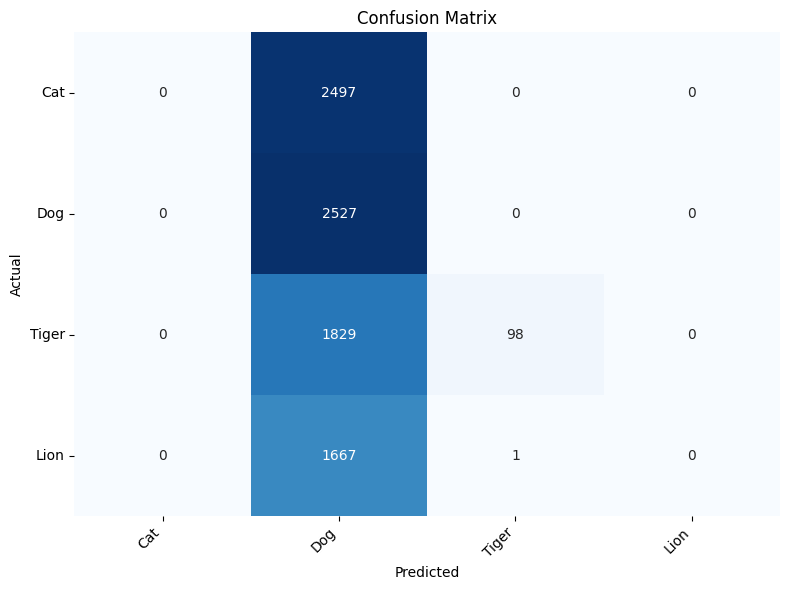

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Assuming y_valid contains the true labels and pred_classes contains the predicted labels
# Replace the class labels with your dataset's actual class names
class_names = ['Cat', 'Dog', 'Tiger', 'Lion']  # Update these based on your dataset

# Generate the confusion matrix
cm = confusion_matrix(y_valid, pred_classes)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names, yticklabels=class_names, cbar=False)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels if needed
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


In [ ]:
from sklearn.metrics import classification_report

# Replace with the actual class names in your dataset
class_names = ['Cat', 'Dog', 'Tiger', 'Lion']

# Display a detailed classification report
print("Classification Report:\n")
print(classification_report(y_valid, pred_classes, target_names=class_names))


Classification Report:

              precision    recall  f1-score   support

         Cat       0.00      0.00      0.00      2497
         Dog       0.30      1.00      0.46      2527
       Tiger       0.99      0.05      0.10      1927
        Lion       0.00      0.00      0.00      1668

    accuracy                           0.30      8619
   macro avg       0.32      0.26      0.14      8619
weighted avg       0.31      0.30      0.16      8619



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


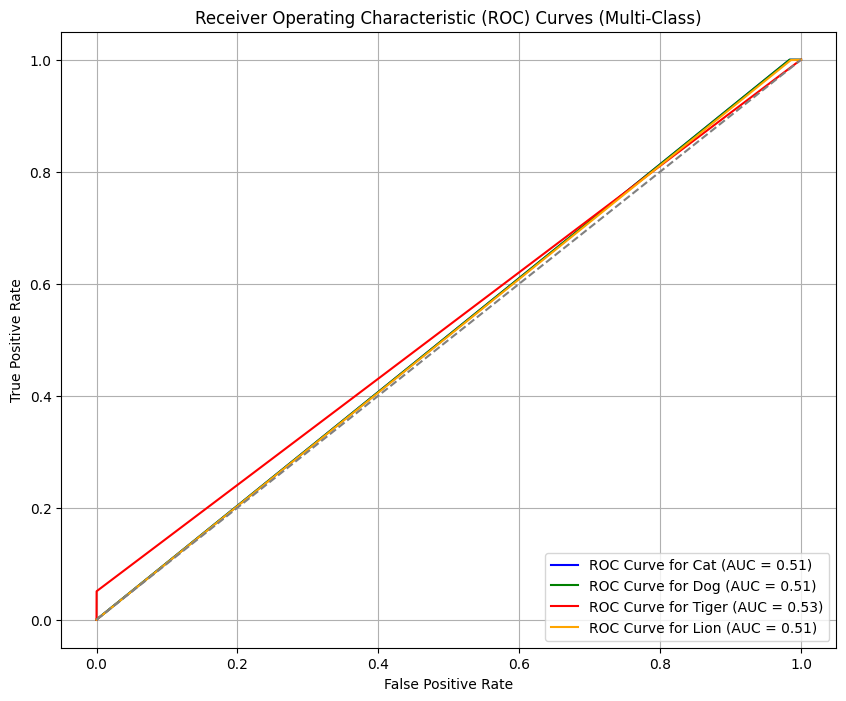

In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt

# Binarize the labels for multi-class ROC
y_valid_binarized = label_binarize(y_valid, classes=[0, 1, 2, 3])  # Assuming class indices are 0: Cat, 1: Dog, 2: Tiger, 3: Lion
n_classes = y_valid_binarized.shape[1]

# Compute ROC curve and AUC for each class
fpr = {}
tpr = {}
roc_auc = {}

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_valid_binarized[:, i], preds[:, i])  # preds should be probabilities for each class
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure(figsize=(10, 8))
colors = ['blue', 'green', 'red', 'orange']
class_names = ['Cat', 'Dog', 'Tiger', 'Lion']

for i, color in enumerate(colors):
    plt.plot(fpr[i], tpr[i], color=color, label=f'ROC Curve for {class_names[i]} (AUC = {roc_auc[i]:.2f})')

# Plot the diagonal line for random guessing
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')

plt.title('Receiver Operating Characteristic (ROC) Curves (Multi-Class)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid()
plt.show()


**Single Convolutional Layer**

In [ ]:
# Define the CNN architecture
IMG_SIZE = (128, 128)  # Example image size (height, width)
num_classes = 4  # Number of classes (cat, dog, tiger, lion)
fc_layer_size = 128

In [ ]:
# Input layer
conv_inputs = keras.Input(shape=(IMG_SIZE[0], IMG_SIZE[1], 3), name='image_input')

# Convolutional layer
conv_layer = layers.Conv2D(24, kernel_size=3, activation='relu')(conv_inputs)
conv_layer = layers.MaxPool2D(pool_size=(2, 2))(conv_layer)

# Flatten the convolutional output
conv_x = layers.Flatten(name='flattened_features')(conv_layer)

# Fully connected layers
conv_x = layers.Dense(fc_layer_size, activation='relu', name='first_layer')(conv_x)
conv_x = layers.Dense(fc_layer_size, activation='relu', name='second_layer')(conv_x)

# Output layer for multi-class classification
conv_outputs = layers.Dense(num_classes, activation='softmax', name='output')(conv_x)

# Create the model
conv_model = Model(inputs=conv_inputs, outputs=conv_outputs)

# Compile the model
customAdam = Adam(learning_rate=1e-6)  # Adjust learning rate as needed
conv_model.compile(
    optimizer=customAdam,
    loss="sparse_categorical_crossentropy",
    metrics=["sparse_categorical_accuracy"]
)

# Print model summary
conv_model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ image_input (InputLayer)             │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 126, 126, 24)        │             672 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 63, 63, 24)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flattened_features (Flatten)         │ (None, 95256)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ first_layer (Dense)                  │ (None, 128)                 │      12,192,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ second_layer (Dense)                 │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output (Dense)                       │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 12,210,596 (46.58 MB)

 Trainable params: 12,210,596 (46.58 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Train the model
history = conv_model.fit(
    train_dataset,               # Pass the training dataset
    epochs=10,                   # Adjust epochs
    batch_size=32,               # Adjust batch size
    shuffle=True,                # Shuffle training data
    validation_data=val_dataset, # Validation dataset
    verbose=1                    # Show progress
)

Epoch 1/10
1078/1078 ━━━━━━━━━━━━━━━━━━━━ 16s 10ms/step - loss: 1.2769 - sparse_categorical_accuracy: 0.4166 - val_loss: 1.1092 - val_sparse_categorical_accuracy: 0.5016
Epoch 2/10
1078/1078 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 1.0863 - sparse_categorical_accuracy: 0.5080 - val_loss: 1.0184 - val_sparse_categorical_accuracy: 0.5433
Epoch 3/10
1078/1078 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.9966 - sparse_categorical_accuracy: 0.5525 - val_loss: 0.9576 - val_sparse_categorical_accuracy: 0.5757
Epoch 4/10
1078/1078 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.9386 - sparse_categorical_accuracy: 0.5798 - val_loss: 0.8998 - val_sparse_categorical_accuracy: 0.5984
Epoch 5/10
1078/1078 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.8862 - sparse_categorical_accuracy: 0.6016 - val_loss: 0.8641 - val_sparse_categorical_accuracy: 0.6126
Epoch 6/10
1078/1078 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.8544 - sparse_categorical_accuracy: 0.6220 - val_loss: 0.8427 - val_sparse_categorical_accurac

In [ ]:
# Predictions
preds = conv_model.predict(val_dataset)
pred_classes = np.argmax(preds, axis=1)  # Convert probabilities to class labels

270/270 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step


In [ ]:
# Extract labels from validation dataset
y_valid = []
for images, labels in val_dataset:
    y_valid.append(labels.numpy())
y_valid = np.concatenate(y_valid)

In [ ]:
# Classification metrics
print("Classification Report:\n")
print(classification_report(y_valid, pred_classes, target_names=['Cat', 'Dog', 'Tiger', 'Lion']))

Classification Report:

              precision    recall  f1-score   support

         Cat       0.61      0.62      0.61      2497
         Dog       0.65      0.68      0.66      2527
       Tiger       0.71      0.71      0.71      1927
        Lion       0.75      0.68      0.71      1668

    accuracy                           0.67      8619
   macro avg       0.68      0.67      0.67      8619
weighted avg       0.67      0.67      0.67      8619



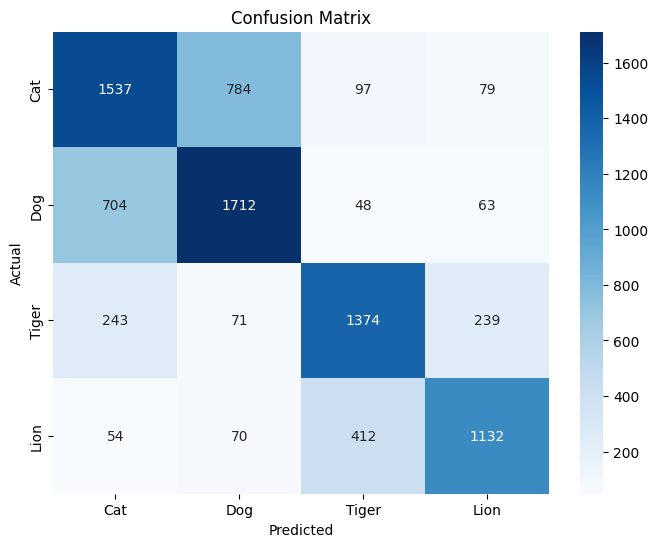

In [ ]:
# Confusion matrix
cm = confusion_matrix(y_valid, pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Cat', 'Dog', 'Tiger', 'Lion'], yticklabels=['Cat', 'Dog', 'Tiger', 'Lion'])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

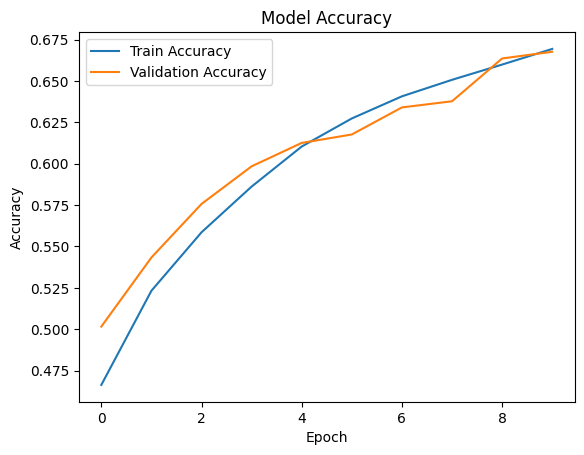

In [ ]:
# Plot training & validation accuracy
plt.plot(history.history['sparse_categorical_accuracy'], label='Train Accuracy')
plt.plot(history.history['val_sparse_categorical_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

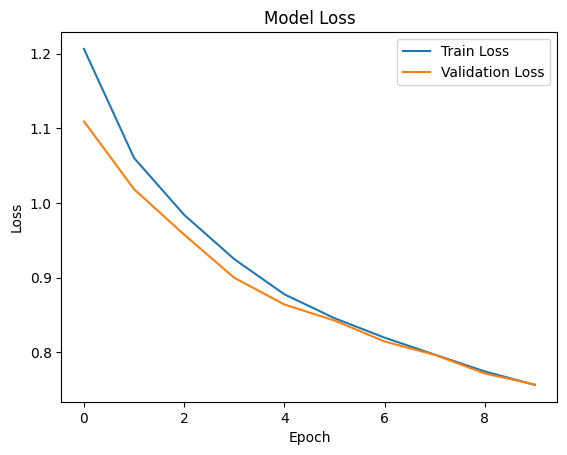

In [ ]:
# Plot training & validation loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

**Neural Network with 2 Convolutional Layers**

In [ ]:
# Define the CNN architecture
IMG_SIZE = (128, 128)  # Example image size (height, width)
num_classes = 4  # Number of classes (cat, dog, tiger, lion)
fc_layer_size = 128

In [ ]:
# Input layer
conv_inputs = keras.Input(shape=(IMG_SIZE[0], IMG_SIZE[1], 3), name='image_input')

# Convolutional layer
conv_layer = layers.Conv2D(24, kernel_size=3, activation='relu')(conv_inputs)
conv_layer = layers.MaxPool2D(pool_size=(2, 2))(conv_layer)

# Flatten the convolutional output
conv_x = layers.Flatten(name='flattened_features')(conv_layer)

# Fully connected layers
conv_x = layers.Dense(fc_layer_size, activation='relu', name='first_layer')(conv_x)
conv_x = layers.Dense(fc_layer_size, activation='relu', name='second_layer')(conv_x)

# Output layer for multi-class classification
conv_outputs = layers.Dense(num_classes, activation='softmax', name='output')(conv_x)

# Create the model
conv_model = Model(inputs=conv_inputs, outputs=conv_outputs)

# Compile the model
customAdam = Adam(learning_rate=1e-6)  # Adjust learning rate as needed
conv_model.compile(
    optimizer=customAdam,
    loss="sparse_categorical_crossentropy",
    metrics=["sparse_categorical_accuracy"]
)

# Print model summary
conv_model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ image_input (InputLayer)             │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 126, 126, 24)        │             672 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 63, 63, 24)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flattened_features (Flatten)         │ (None, 95256)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ first_layer (Dense)                  │ (None, 128)                 │      12,192,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ second_layer (Dense)                 │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output (Dense)                       │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 12,210,596 (46.58 MB)

 Trainable params: 12,210,596 (46.58 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Train the model
history = conv_model.fit(
    train_dataset,               # Pass the training dataset
    epochs=10,                   # Adjust epochs
    batch_size=32,               # Adjust batch size
    shuffle=True,                # Shuffle training data
    validation_data=val_dataset, # Validation dataset
    verbose=1                    # Show progress
)

Epoch 1/10
1078/1078 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - loss: 1.2931 - sparse_categorical_accuracy: 0.3855 - val_loss: 1.1000 - val_sparse_categorical_accuracy: 0.5155
Epoch 2/10
1078/1078 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 1.0610 - sparse_categorical_accuracy: 0.5289 - val_loss: 0.9798 - val_sparse_categorical_accuracy: 0.5677
Epoch 3/10
1078/1078 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.9584 - sparse_categorical_accuracy: 0.5779 - val_loss: 0.9209 - val_sparse_categorical_accuracy: 0.5911
Epoch 4/10
1078/1078 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.9013 - sparse_categorical_accuracy: 0.6029 - val_loss: 0.8738 - val_sparse_categorical_accuracy: 0.6174
Epoch 5/10
1078/1078 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.8613 - sparse_categorical_accuracy: 0.6195 - val_loss: 0.8377 - val_sparse_categorical_accuracy: 0.6396
Epoch 6/10
1078/1078 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.8282 - sparse_categorical_accuracy: 0.6370 - val_loss: 0.8138 - val_sparse_categorical_accuracy

In [ ]:
# Predictions
preds = conv_model.predict(val_dataset)
pred_classes = np.argmax(preds, axis=1)  # Convert probabilities to class labels

# Extract labels from validation dataset
y_valid = []
for images, labels in val_dataset:
    y_valid.append(labels.numpy())
y_valid = np.concatenate(y_valid)


270/270 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step


In [ ]:
# Classification metrics
print("Classification Report:\n")
print(classification_report(y_valid, pred_classes, target_names=['Cat', 'Dog', 'Tiger', 'Lion']))


Classification Report:

              precision    recall  f1-score   support

         Cat       0.65      0.57      0.61      2497
         Dog       0.66      0.67      0.66      2527
       Tiger       0.74      0.82      0.78      1927
        Lion       0.68      0.72      0.70      1668

    accuracy                           0.68      8619
   macro avg       0.68      0.69      0.69      8619
weighted avg       0.68      0.68      0.68      8619



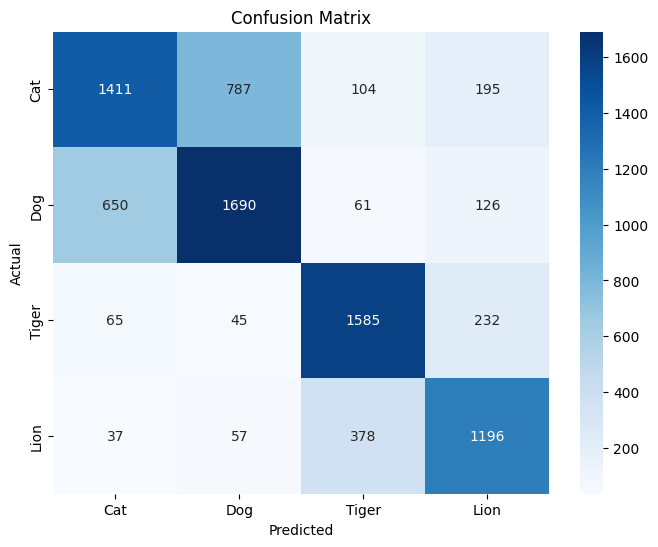

In [ ]:
# Confusion matrix
cm = confusion_matrix(y_valid, pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Cat', 'Dog', 'Tiger', 'Lion'], yticklabels=['Cat', 'Dog', 'Tiger', 'Lion'])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

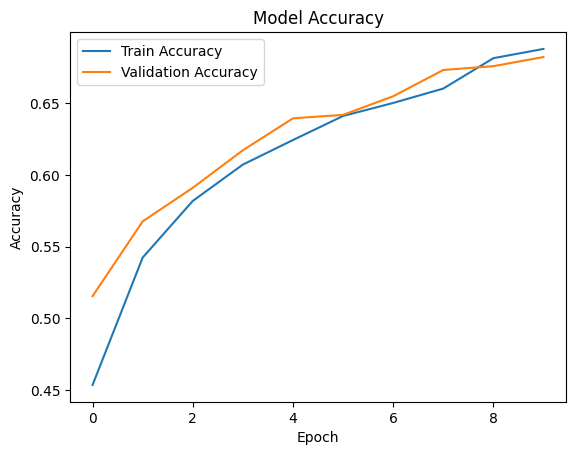

In [ ]:
# Plot training & validation accuracy
plt.plot(history.history['sparse_categorical_accuracy'], label='Train Accuracy')
plt.plot(history.history['val_sparse_categorical_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

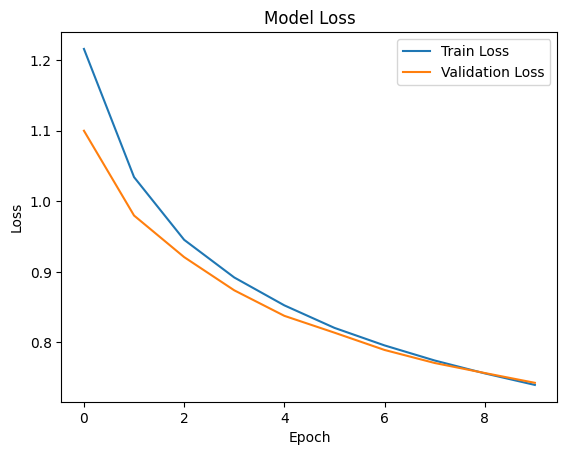

In [ ]:
# Plot training & validation loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

**Huge Model**

In [ ]:
from tensorflow.keras import layers, optimizers, Model
# Define a larger CNN model
def create_huge_cnn_model(input_shape=(128, 128, 3), num_classes=4, fc_layer_size=128):
    conv_inputs = layers.Input(shape=input_shape, name='input_image')

    # Add multiple Conv2D + MaxPooling layers for deeper feature extraction
    conv_layer = layers.Conv2D(128, kernel_size=3, activation='relu', padding='same')(conv_inputs)
    conv_layer = layers.MaxPooling2D(pool_size=(2, 2))(conv_layer)

    conv_layer = layers.Conv2D(128, kernel_size=3, activation='relu', padding='same')(conv_layer)
    conv_layer = layers.MaxPooling2D(pool_size=(2, 2))(conv_layer)

    conv_layer = layers.Conv2D(256, kernel_size=3, activation='relu', padding='same')(conv_layer)
    conv_layer = layers.MaxPooling2D(pool_size=(2, 2))(conv_layer)

    conv_layer = layers.Conv2D(256, kernel_size=3, activation='relu', padding='same')(conv_layer)
    conv_layer = layers.MaxPooling2D(pool_size=(2, 2))(conv_layer)

    conv_layer = layers.Conv2D(512, kernel_size=3, activation='relu', padding='same')(conv_layer)
    conv_layer = layers.MaxPooling2D(pool_size=(2, 2))(conv_layer)

    # Flatten the output to feed into fully connected layers
    conv_x = layers.Flatten()(conv_layer)

    # Add dense layers for classification
    conv_x = layers.Dense(fc_layer_size, activation='relu')(conv_x)
    conv_x = layers.Dropout(0.5)(conv_x)
    conv_x = layers.Dense(fc_layer_size, activation='relu')(conv_x)
    conv_x = layers.Dropout(0.5)(conv_x)

    # Output layer for multi-class classification
    conv_outputs = layers.Dense(num_classes, activation='softmax', name='output')(conv_x)

    # Create and compile the model
    huge_conv_model = Model(inputs=conv_inputs, outputs=conv_outputs)
    customAdam = optimizers.Adam(learning_rate=1e-4)
    huge_conv_model.compile(
        optimizer=customAdam,
        loss='sparse_categorical_crossentropy',
        metrics=['sparse_categorical_accuracy']
    )

    return huge_conv_model

# Instantiate the model
huge_model = create_huge_cnn_model()

# Summary of the model
huge_model.summary()


Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_image (InputLayer)             │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_26 (Conv2D)                   │ (None, 128, 128, 128)       │           3,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_26 (MaxPooling2D)      │ (None, 64, 64, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_27 (Conv2D)                   │ (None, 64, 64, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_27 (MaxPooling2D)      │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_28 (Conv2D)                   │ (None, 32, 32, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_28 (MaxPooling2D)      │ (None, 16, 16, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_29 (Conv2D)                   │ (None, 16, 16, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_29 (MaxPooling2D)      │ (None, 8, 8, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_30 (Conv2D)                   │ (None, 8, 8, 512)           │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_30 (MaxPooling2D)      │ (None, 4, 4, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_4 (Flatten)                  │ (None, 8192)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 128)                 │       1,048,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output (Dense)                       │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,282,308 (12.52 MB)

 Trainable params: 3,282,308 (12.52 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Train the model
EPOCHS = 10
history = huge_model.fit(
    train_dataset,                # Use your prepared train dataset
    validation_data=val_dataset,  # Use your prepared validation dataset
    epochs=EPOCHS,
    batch_size=32,
    shuffle=True,
    verbose=1
)



Epoch 1/10
1078/1078 ━━━━━━━━━━━━━━━━━━━━ 21s 16ms/step - loss: 1.0847 - sparse_categorical_accuracy: 0.4635 - val_loss: 0.5879 - val_sparse_categorical_accuracy: 0.6906
Epoch 2/10
1078/1078 ━━━━━━━━━━━━━━━━━━━━ 12s 11ms/step - loss: 0.6399 - sparse_categorical_accuracy: 0.6835 - val_loss: 0.5811 - val_sparse_categorical_accuracy: 0.7465
Epoch 3/10
1078/1078 ━━━━━━━━━━━━━━━━━━━━ 12s 11ms/step - loss: 0.5152 - sparse_categorical_accuracy: 0.7628 - val_loss: 0.4276 - val_sparse_categorical_accuracy: 0.8151
Epoch 4/10
1078/1078 ━━━━━━━━━━━━━━━━━━━━ 12s 11ms/step - loss: 0.4470 - sparse_categorical_accuracy: 0.8053 - val_loss: 0.3569 - val_sparse_categorical_accuracy: 0.8492
Epoch 5/10
1078/1078 ━━━━━━━━━━━━━━━━━━━━ 12s 11ms/step - loss: 0.3805 - sparse_categorical_accuracy: 0.8394 - val_loss: 0.3453 - val_sparse_categorical_accuracy: 0.8511
Epoch 6/10
1078/1078 ━━━━━━━━━━━━━━━━━━━━ 12s 11ms/step - loss: 0.3405 - sparse_categorical_accuracy: 0.8622 - val_loss: 0.2927 - val_sparse_categoric

In [ ]:
# Evaluate the model
pred_probs = huge_model.predict(val_dataset)
pred_classes = np.argmax(pred_probs, axis=1)

# Extract labels from the validation dataset
y_valid = []
for images, labels in val_dataset:
    y_valid.append(labels.numpy())
y_valid = np.concatenate(y_valid)


270/270 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step


In [ ]:
# Calculate evaluation metrics
accuracy = accuracy_score(y_valid, pred_classes)
precision = precision_score(y_valid, pred_classes, average='macro')
recall = recall_score(y_valid, pred_classes, average='macro')
f1 = f1_score(y_valid, pred_classes, average='macro')
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")


Accuracy: 0.9245
Precision: 0.9282
Recall: 0.9291
F1 Score: 0.9284


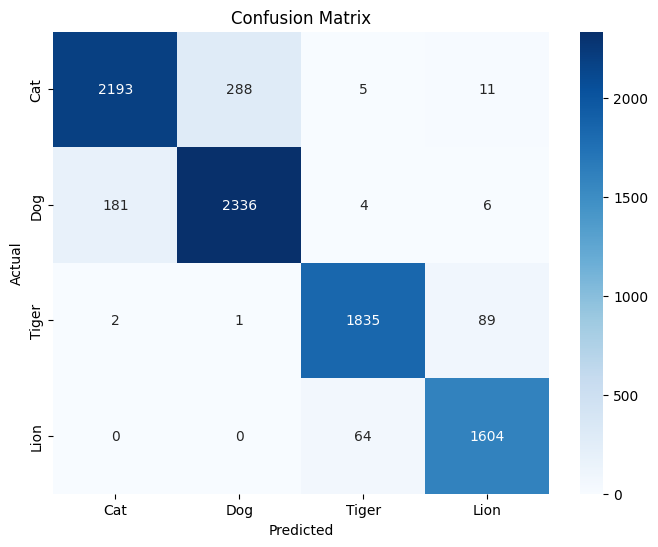

In [ ]:
# Generate confusion matrix
cm = confusion_matrix(y_valid, pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Cat', 'Dog', 'Tiger', 'Lion'], yticklabels=['Cat', 'Dog', 'Tiger', 'Lion'])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


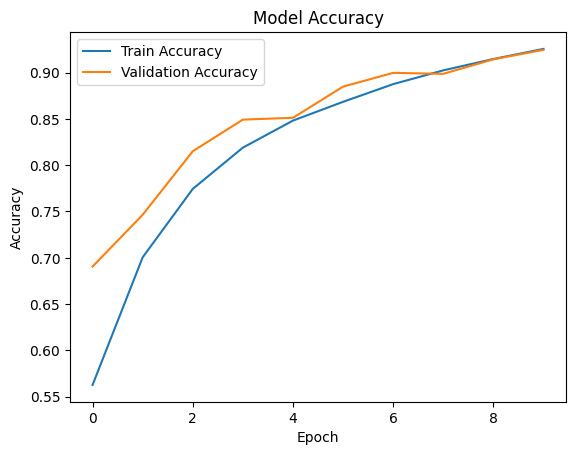

In [ ]:
# Plot training & validation accuracy
plt.plot(history.history['sparse_categorical_accuracy'], label='Train Accuracy')
plt.plot(history.history['val_sparse_categorical_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

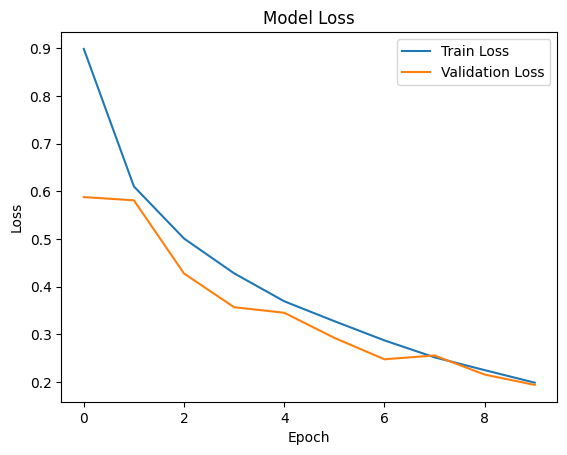

In [ ]:
# Plot training & validation loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

**VGG LIKE MODEL**

In [ ]:
from tensorflow.keras import layers, models, optimizers

# Define the input shape
input_shape = (128, 128, 3)  # Update the input shape

# Define the input layer
conv_inputs = layers.Input(shape=input_shape)

# First convolutional block
conv_layer = layers.Conv2D(64, kernel_size=3, activation='relu', padding='same')(conv_inputs)
conv_layer = layers.BatchNormalization()(conv_layer)
conv_layer = layers.Conv2D(64, kernel_size=3, activation='relu', padding='same')(conv_layer)
conv_layer = layers.MaxPooling2D(pool_size=(2, 2))(conv_layer)

# Second convolutional block
conv_layer = layers.Conv2D(128, kernel_size=3, activation='relu', padding='same')(conv_layer)
conv_layer = layers.BatchNormalization()(conv_layer)
conv_layer = layers.Conv2D(128, kernel_size=3, activation='relu', padding='same')(conv_layer)
conv_layer = layers.MaxPooling2D(pool_size=(2, 2))(conv_layer)

# Third convolutional block
conv_layer = layers.Conv2D(256, kernel_size=3, activation='relu', padding='same')(conv_layer)
conv_layer = layers.BatchNormalization()(conv_layer)
conv_layer = layers.Conv2D(256, kernel_size=3, activation='relu', padding='same')(conv_layer)
conv_layer = layers.MaxPooling2D(pool_size=(2, 2))(conv_layer)

# Fourth convolutional block
conv_layer = layers.Conv2D(512, kernel_size=3, activation='relu', padding='same')(conv_layer)
conv_layer = layers.BatchNormalization()(conv_layer)
conv_layer = layers.Conv2D(512, kernel_size=3, activation='relu', padding='same')(conv_layer)
conv_layer = layers.MaxPooling2D(pool_size=(2, 2))(conv_layer)

# Flatten the output
flattened = layers.Flatten()(conv_layer)

# Fully connected layers with Dropout
fc_layer = layers.Dense(128, activation='relu')(flattened)  # Use fc_layer_size directly here
fc_layer = layers.Dropout(0.5)(fc_layer)
fc_layer = layers.Dense(128, activation='relu')(fc_layer)  # Same fc_layer_size

# Output layer for multiclass classification
output = layers.Dense(4, activation='softmax', name='output')(fc_layer)  # 4 classes

# Create the model
vgg_model_multiclass = models.Model(inputs=conv_inputs, outputs=output)

# Compile the model
vgg_model_multiclass.compile(
    optimizer=optimizers.Adam(learning_rate=1e-4),  # Adjust learning rate if necessary
    loss='sparse_categorical_crossentropy',         # Use 'sparse_categorical_crossentropy' for integer labels
    metrics=['sparse_categorical_accuracy']
)

# Show the model summary
vgg_model_multiclass.summary()


Model: "functional_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_63 (Conv2D)                   │ (None, 128, 128, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_16               │ (None, 128, 128, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_64 (Conv2D)                   │ (None, 128, 128, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_47 (MaxPooling2D)      │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_65 (Conv2D)                   │ (None, 64, 64, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_17               │ (None, 64, 64, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_66 (Conv2D)                   │ (None, 64, 64, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_48 (MaxPooling2D)      │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_67 (Conv2D)                   │ (None, 32, 32, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_18               │ (None, 32, 32, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_68 (Conv2D)                   │ (None, 32, 32, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_49 (MaxPooling2D)      │ (None, 16, 16, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_69 (Conv2D)                   │ (None, 16, 16, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_19               │ (None, 16, 16, 512)         │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_70 (Conv2D)                   │ (None, 16, 16, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_50 (MaxPooling2D)      │ (None, 8, 8, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_9 (Flatten)                  │ (None, 32768)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_22 (Dense)                     │ (None, 128)                 │       4,194,432 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 8,900,676 (33.95 MB)

 Trainable params: 8,898,756 (33.95 MB)

 Non-trainable params: 1,920 (7.50 KB)

In [ ]:
# Train the model
EPOCHS = 15
history = vgg_model_multiclass.fit(
    train_dataset,                # Use your prepared train dataset
    validation_data=val_dataset,  # Use your prepared validation dataset
    epochs=EPOCHS,
    batch_size=32,
    shuffle=True,
    verbose=1
)


Epoch 1/15
1078/1078 ━━━━━━━━━━━━━━━━━━━━ 21s 19ms/step - loss: 0.1577 - sparse_categorical_accuracy: 0.9374 - val_loss: 0.1925 - val_sparse_categorical_accuracy: 0.9226
Epoch 2/15
1078/1078 ━━━━━━━━━━━━━━━━━━━━ 21s 19ms/step - loss: 0.1501 - sparse_categorical_accuracy: 0.9422 - val_loss: 0.1322 - val_sparse_categorical_accuracy: 0.9520
Epoch 3/15
1078/1078 ━━━━━━━━━━━━━━━━━━━━ 21s 19ms/step - loss: 0.1210 - sparse_categorical_accuracy: 0.9530 - val_loss: 0.1820 - val_sparse_categorical_accuracy: 0.9375
Epoch 4/15
1078/1078 ━━━━━━━━━━━━━━━━━━━━ 21s 19ms/step - loss: 0.0969 - sparse_categorical_accuracy: 0.9627 - val_loss: 0.3016 - val_sparse_categorical_accuracy: 0.8856
Epoch 5/15
1078/1078 ━━━━━━━━━━━━━━━━━━━━ 21s 19ms/step - loss: 0.0757 - sparse_categorical_accuracy: 0.9729 - val_loss: 0.2266 - val_sparse_categorical_accuracy: 0.9202
Epoch 6/15
1078/1078 ━━━━━━━━━━━━━━━━━━━━ 21s 19ms/step - loss: 0.0673 - sparse_categorical_accuracy: 0.9768 - val_loss: 0.1623 - val_sparse_categoric

In [ ]:
# Evaluate the model
pred_probs = vgg_model_multiclass.predict(val_dataset)  # Use vgg_model instead of huge_model
pred_classes = np.argmax(pred_probs, axis=1)

# Extract labels from the validation dataset
y_valid = []
for images, labels in val_dataset:
    y_valid.append(labels.numpy())  # Ensure labels are extracted as numpy arrays
y_valid = np.concatenate(y_valid)

270/270 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step


In [ ]:
# Calculate evaluation metrics for multiclass classification
accuracy = accuracy_score(y_valid, pred_classes)
precision = precision_score(y_valid, pred_classes, average='macro')  # No need for num_classes
recall = recall_score(y_valid, pred_classes, average='macro')  # No need for num_classes
f1 = f1_score(y_valid, pred_classes, average='macro')  # No need for num_classes

# Print the evaluation metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Accuracy: 0.9420
Precision: 0.9470
Recall: 0.9441
F1 Score: 0.9447


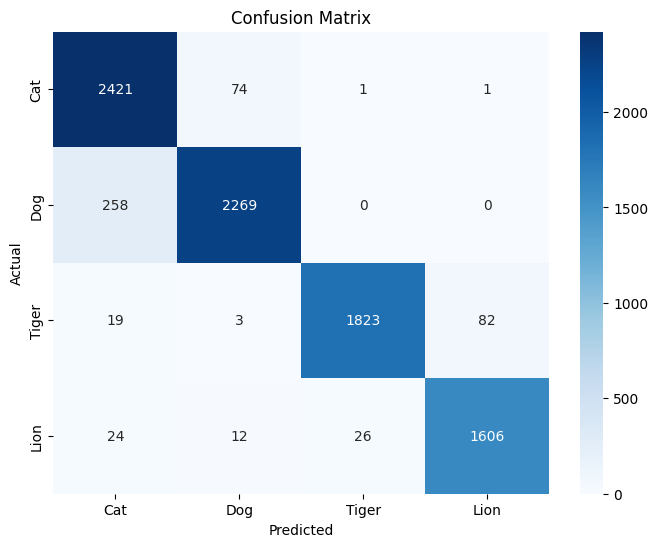

In [ ]:
# Generate confusion matrix
cm = confusion_matrix(y_valid, pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Cat', 'Dog', 'Tiger', 'Lion'], yticklabels=['Cat', 'Dog', 'Tiger', 'Lion'])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


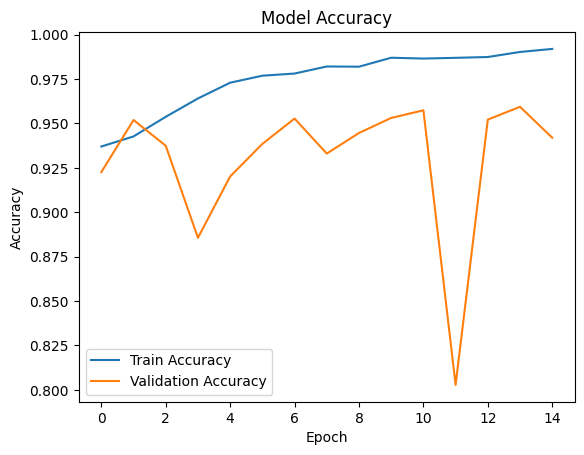

In [ ]:
# Plot training & validation accuracy
plt.plot(history.history['sparse_categorical_accuracy'], label='Train Accuracy')
plt.plot(history.history['val_sparse_categorical_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

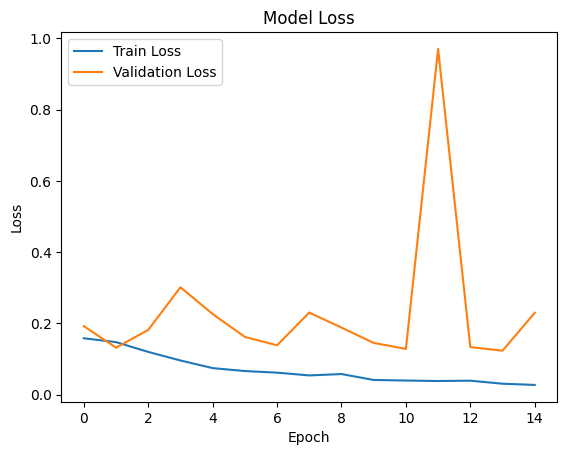

In [ ]:
# Plot training & validation loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


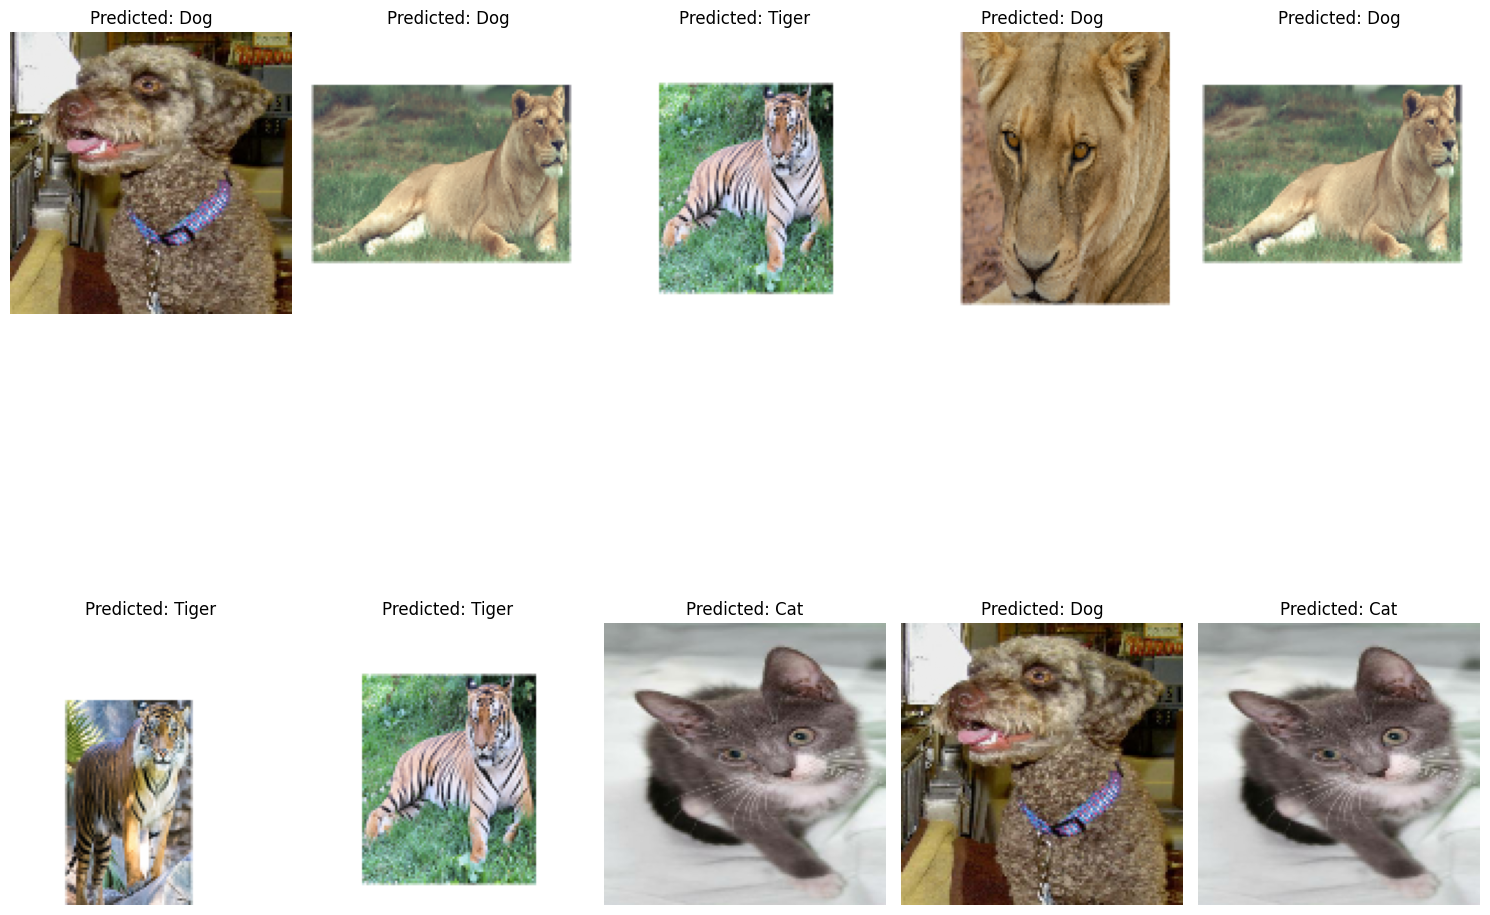

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Function to visualize predictions
def visualize_predictions(model, test_dfs, class_labels=['Cat', 'Dog', 'Tiger', 'Lion'], num_samples=10):
    """
    Visualizes predictions for a given model and test datasets.

    Parameters:
    - model: Trained TensorFlow/Keras model to make predictions.
    - test_dfs: Dictionary of DataFrames for test datasets for each class (e.g., CatDog, Lion, Tiger).
    - class_labels: List of class labels for predictions.
    - num_samples: Total number of samples to visualize (evenly distributed across classes).
    """
    # Initialize lists to store images and predictions
    images, predictions = [], []

    # Calculate how many samples to take from each test DataFrame
    samples_per_class = num_samples // len(test_dfs)

    # Collect samples from each class
    for class_name, test_df in test_dfs.items():
        # Shuffle and sample the DataFrame
        sampled_df = test_df.sample(n=min(samples_per_class, len(test_df)), random_state=42)

        for file_path, label in zip(sampled_df['image_path'], sampled_df['label']):
            # Load and preprocess the image
            img = load_and_preprocess_image(file_path)
            images.append(img.numpy())

            # Prepare the image for the model
            img_array = np.expand_dims(img.numpy(), axis=0)  # Expand dimensions to match input shape

            # Make a prediction
            prediction = model.predict(img_array)
            # Map the prediction to the corresponding class label
            predicted_label = class_labels[int(np.argmax(prediction))]  # Multi-class classification assumption
            predictions.append(predicted_label)

    # If the number of images is less than num_samples, add more images randomly from the classes
    total_samples = len(images)
    if total_samples < num_samples:
        extra_samples_needed = num_samples - total_samples
        all_indices = np.random.permutation(len(images))
        images.extend([images[i] for i in all_indices[:extra_samples_needed]])
        predictions.extend([predictions[i] for i in all_indices[:extra_samples_needed]])

    # Shuffle the collected samples to add randomness
    shuffled_indices = np.random.permutation(len(images))
    images = [images[i] for i in shuffled_indices]
    predictions = [predictions[i] for i in shuffled_indices]

    # Visualize the images with their predicted labels
    plt.figure(figsize=(15, 15))
    for i in range(num_samples):
        if i >= len(images):  # Ensure we don't go out of bounds
            break
        plt.subplot(2, 5, i + 1)
        plt.imshow(images[i])
        plt.title(f"Predicted: {predictions[i]}")  # Only show predicted label
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Testing the function
test_dfs = {
    'Cat': cat_dog_test_df[cat_dog_test_df['label'] == 'Cat'],
    'Dog': cat_dog_test_df[cat_dog_test_df['label'] == 'Dog'],
    'Lion': lion_test_df,
    'Tiger': tiger_test_df
}

visualize_predictions(vgg_model_multiclass, test_dfs, num_samples=10)
